Numerical Example of ADMM
--
* [M. Tao, J. Yang, Alternating Direction Algorithms for Total Variation Deconvolution in Image Reconstruction.](https://sites.fas.harvard.edu/~cs278/papers/adm.pdf)
* [M. Tao, J. Yang, A New Alterating Minimization Algorithm for Total Variation Image Reconstruction.](https://www.caam.rice.edu/~yzhang/reports/tr0710_rev.pdf)
* [小野 峻佑さんのHP](https://sites.google.com/site/thunsukeono/japanese)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.data import camera
from skimage.measure import compare_psnr

cmap = 'gray'

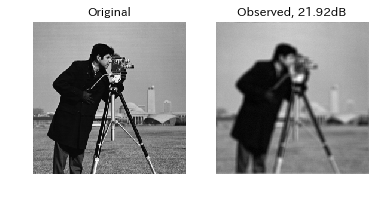

In [8]:
from scipy.fftpack import fft2, ifft2

im_org = camera().astype(np.float)[::2, ::2]
row, col = im_org.shape

# blur operator
psfsize = 7
psf = np.ones((psfsize, psfsize))
psf /= np.sum(psf)
blu = np.zeros(im_org.shape)
blu[:psf.shape[0], :psf.shape[1]] = psf
blu = np.roll(blu, -(psfsize // 2), 0)
blu = np.roll(blu, -(psfsize // 2), 1)
bluf = fft2(blu)
bluft = np.conj(bluf)
Phi = lambda z: ifft2(fft2(z) * bluf).real
Phit = lambda z: ifft2(fft2(z) * bluft).real

sigma = np.sqrt(2) # noise standard deviation

im_obs = Phi(im_org) + np.random.randn(row, col) * sigma

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax = ax.flatten()

ax[0].imshow(im_org, cmap=cmap)
ax[1].imshow(im_obs, cmap=cmap)

ax[0].set_title('Original')
ax[1].set_title('Observed, {:.2f}dB'.format(compare_psnr(im_org / 255, im_obs / 255)))

for a in ax:
    a.axis('off')
    
plt.savefig("original_observed.png", dpi=220)

Text(0.5,1,'TV')

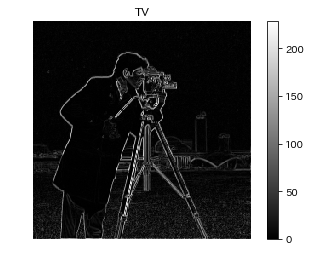

In [9]:
D = lambda z: np.dstack((np.roll(z, -1, 0) - z, np.roll(z, -1, 1) - z))
TV = lambda z: np.linalg.norm(D(z), ord=2, axis=2)

plt.imshow(TV(im_org), cmap=cmap)
plt.axis('off')
plt.colorbar()
plt.title("TV")

Text(0.5,1,'TV by FFT')

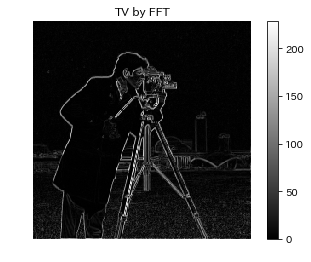

In [10]:
buf = np.zeros_like(im_org)
buf[row // 2, col // 2] = 1.
d = D(buf)
d = np.roll(d, -(row // 2), 0)
d= np.roll(d, -(col // 2), 1)

D1f = fft2(d[:, :, 0])
D2f = fft2(d[:, :, 1])
D1ft = np.conj(D1f)
D2ft = np.conj(D2f)

fft_conv = lambda z, psf: ifft2(fft2(z) * psf).real
fft_TV = lambda z: np.sqrt(fft_conv(z, D1f) ** 2 + fft_conv(z, D2f) ** 2)  

plt.imshow(fft_TV(im_org), cmap=cmap)
plt.axis('off')
plt.colorbar()
plt.title("TV by FFT")

10 25.4434657527
20 26.3769441177
30 26.9085537847
40 27.2693315165
50 27.5343587188
60 27.7379478424
70 27.898867286
80 28.0286539726
90 28.1357299599
100 28.2260100987
110 28.3029319987
120 28.3685415346
130 28.4250295712
140 28.4740350893
150 28.5167243105
160 28.5541359324
170 28.5871502392
180 28.6162796938
190 28.6419888931
200 28.6647926315
210 28.6850682686
220 28.7031807459
230 28.7193830873
240 28.7339360155
250 28.747159119
260 28.759137379
270 28.7699449118
280 28.7797501098
290 28.7886693528
300 28.7967555616
310 28.804080566
320 28.8108580976
330 28.8170979108
340 28.822807736
350 28.8280506146
360 28.8328954152
370 28.8373253539
380 28.8413550777
390 28.8450835027
400 28.8485175395
410 28.8516533448
420 28.8545417186
430 28.8572416574
440 28.8597247692
450 28.8620110148
460 28.8641179367
470 28.8660637446
480 28.8678298389
490 28.8694316834
500 28.8708955643
510 28.872253074
520 28.8735397583
530 28.8747272693
540 28.8758243851
550 28.876826456
560 28.8777460436
570 28.8

Text(0.5,1,'Restored, 28.89')

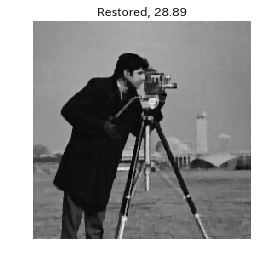

In [11]:
x = im_obs.copy()
lam = np.zeros((row, col, 2))
beta = sigma ** 2
myu = 10.
gamm = 1.618
N_iter = 2000
eps = 1e-5

im_obsf = fft2(im_obs)

def shrink2D(im, lam, beta):
    diff = D(im) + lam / beta
    norm = np.linalg.norm(diff, ord=2, axis=2, keepdims=True)
    coeff = norm - 1 / beta
    coeff *= coeff > 0
    return coeff* diff / norm

def shrink1D(im, lam, beta):
    diff = D(im) + lam / beta
    coeff = np.abs(diff) - 1 / beta
    coeff *= coeff > 0
    return coeff * np.sign(diff)
 
def ls(x, y, lam, myu, beta, D1f, D2f, D1ft, D2ft, bluf, bluft, im_obsf):
        w = y - lam / beta
        w1f = fft2(w[:, :, 0])
        w2f = fft2(w[:, :, 1])
        a = D1ft * w1f + D2ft * w2f + (myu / beta) * bluft * im_obsf
        b = D1ft * D1f + D2ft * D2f + (myu / beta)  * bluft * bluf
        return ifft2(a / b).real
    
norm = lambda z: np.sqrt(np.sum(z ** 2))
    
for i in range(N_iter):
    y = shrink2D(x, lam, beta)
    x_new = ls(x, y, lam, myu, beta, D1f, D2f, D1ft, D2ft, bluf, bluft, im_obsf)
    lam = lam - gamm * beta * (y - D(x_new))

    e = norm(x_new - x) / np.max((norm(x), 1))
    x = x_new
    if i % 10 == 9:
        print(i + 1, compare_psnr(im_org / 255, x / 255))
    if e < eps:
        break
    
plt.imshow(x, cmap=cmap)
plt.axis('off')
plt.title("Restored, {:.2f}".format(compare_psnr(im_org / 255, x / 255)))

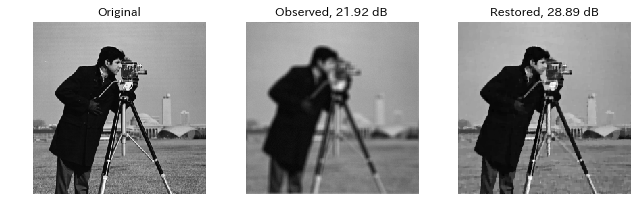

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax = ax.flatten()

vmin = im_org.min()
vmax = im_org.max()

ax[0].imshow(im_org, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1].imshow(im_obs, cmap=cmap, vmin=vmin, vmax=vmax)
ax[2].imshow(x, cmap=cmap, vmin=vmin, vmax=vmax)

ax[0].set_title('Original')
ax[1].set_title('Observed, {:.2f} dB'.format(compare_psnr(im_org / 255, im_obs / 255)))
ax[2].set_title('Restored, {:.2f} dB'.format(compare_psnr(im_org / 255, x / 255)))

for a in ax:
    a.axis('off')
    
plt.tight_layout()
plt.savefig("numerical_example.png", dpi=220)